# Sensitivity Analysis for COVID Testing Method
Fred Lu
11/14/2020

First half is setup and is same as main notebook. Skip to sensitivity analysis section.

## Setup data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from data.us_state_abbrev import *

In [2]:
DATA_LOC = Path('./data')
RESULTS_LOC = Path('./results')
ILI_NAT = DATA_LOC / 'national'
ILI_STS = DATA_LOC / 'states'

TEST_RES = DATA_LOC / 'covid_tests_state_updated.csv'

### Load state-level ILI

In [3]:
# Load the data.
data = {}
data['national'] = {
    'clinical': pd.read_csv(ILI_NAT / 'WHO_NREVSS_Clinical_Labs.csv', skiprows=1, na_values='X'),
    'ili': pd.read_csv(ILI_NAT / 'ILINet.csv', skiprows=1, na_values='X')
}
data['state'] = {
    'clinical': pd.read_csv(ILI_STS / 'WHO_NREVSS_Clinical_Labs.csv', skiprows=1, na_values='X'),
    'ili': pd.read_csv(ILI_STS / 'ILINet.csv', skiprows=1, na_values='X')
}

In [4]:
# Load the date map.
date_map = pd.read_csv(DATA_LOC / 'CDC_week_lookup.csv')

# Add the Sunday dates and compute total positive for virology data.
for dres in data.keys():
    for dsource in data[dres]:
        data[dres][dsource] = pd.merge(data[dres][dsource], date_map, 
                                       how='left', 
                                       left_on=['YEAR','WEEK'], 
                                       right_on = ['YEAR','WEEK'])
        if dsource == 'clinical':
            data[dres][dsource]['TOTAL POSITIVE'] = data[dres][dsource]['TOTAL A']+data[dres][dsource]['TOTAL B']

In [5]:
data['national']['clinical'].tail()

,REGION TYPE,REGION,YEAR,WEEK,TOTAL SPECIMENS,TOTAL A,TOTAL B,PERCENT POSITIVE,PERCENT A,PERCENT B,Sunday,TOTAL POSITIVE
236,National,NaN,2020,16,13709,33,24,0.415785,0.240718,0.175067,4/12/2020,57
237,National,NaN,2020,17,12044,20,7,0.224178,0.166058,0.058120,4/19/2020,27
238,National,NaN,2020,18,9600,19,8,0.281250,0.197917,0.083333,4/26/2020,27
239,National,NaN,2020,19,8274,12,13,0.302151,0.145033,0.157119,5/3/2020,25
240,National,NaN,2020,20,6007,9,7,0.266356,0.149825,0.116531,5/10/2020,16


### Load COVID-19 testing data

In [6]:
from pandas.tseries.offsets import Week

# load testing data
tests = pd.read_csv(TEST_RES)
tests['Date'] = pd.to_datetime(tests['Date'], format='%Y%m%d')
tests['Sunday'] = tests['Date'] - Week(weekday=6)
tests['State'] = tests['State'].map(lambda x: abbrev_us_state[x])

# drop updated columns for now
tests.drop(['Data Quality Grade', 'Last Update ET'], axis=1, inplace=True)

cols = list(set(tests.columns) - set(['Date', 'State', 'Sunday']))
tests[cols] = tests[cols].replace(',', '', regex=True)
tests[cols] = tests[cols].astype(float)

# copy NY entries for New York City since ILINet has separate entry for NYC
nyc = tests[tests['State'] == 'New York'].copy()
nyc['State'] = 'New York City'
tests = pd.concat([tests, nyc], axis=0)

tests.sort_values(['State', 'Date'], inplace=True)

Reported case data are cumulative over time, so apply differencing to get daily changes. Because of delay issues in the test reporting where sometimes no negative results are added over a whole week, we use the cumulative end-of-week test results for our analysis estimates. Otherwise we run into occasional issues where 100% of tests in a week are positive. Since the number of tests increases rapidly over the course of the study, using cumulative test counts essentially has a mild smoothing effect.

Update for May 2020: Since we now have significantly more weeks of information and the case counts are no longer exponentially increasing, we have updated the test aggregation from cumulative to a rolling interval of three weeks (that is, each week's proportion is computed from the sum cases including the previous two weeks). This results in a local smoothing effect. To match the smoothing effect in the ILI data so that the data are more analogous, we apply the same process to the ILI reporting data in each state. This helps correct for week-to-week noise as with the COVID-19 testing, but also may adjust for reporting delays where cases are better represented from the previous week's conditions. One of the caveats of our method of nowcasting using ILI is that ILI reporting coverage and patient counts drops as the flu season ends, resulting in low ILI counts. This indicates an increasing mismatch between the ILINet patient sample and the potential COVID-19-positive patient sample. The smoothing process mitigates that factor a little.

In [7]:
# apply differencing to get daily changes
tests_full = tests.copy()
tests = tests.loc[:, ['Date', 'Sunday', 'State', 'Positive', 'Negative']]
tests[['Positive', 'Negative']] = tests.groupby('State')[['Positive', 'Negative']].transform(lambda x: x.ffill())
tests[['pos_new', 'neg_new']] = tests.groupby('State')[['Positive', 'Negative']].transform(lambda x: x.diff(1))
tests.fillna(0, inplace=True)

In [8]:
tests[tests.State == 'New York'].head()

,Date,Sunday,State,Positive,Negative,pos_new,neg_new
4554,2020-03-04,2020-03-01,New York,6.0,48.0,0.0,0.0
4536,2020-03-05,2020-03-01,New York,22.0,76.0,16.0,28.0
4509,2020-03-06,2020-03-01,New York,33.0,92.0,11.0,16.0
4469,2020-03-07,2020-03-01,New York,76.0,92.0,43.0,0.0
4419,2020-03-08,2020-03-01,New York,105.0,92.0,29.0,0.0


There are varying estimates for the false negative rate for the RT-PCR used in Covid-19 tests. The concerns generally stem from the sample collection process which may fail to collect virus rather than the RT-PCR process itself. Our standard analysis uses 15%, and we repeat the study with a somewhat extreme 25% and a very conservative 5%. Reports from some doctors and studies lend support to false negative rates as high as 25-30%.

On the other hand, RT-PCR is highly specific, so we assume a false positive rate of 0. 

In [9]:
# adjust for assumed false negative rate
FN_RATE = 0.15

def compute_false_neg(true_pos, false_neg_rate):
    ''' additive adjustment for false negative rate based on number of positive tests '''
    return false_neg_rate * true_pos / (1 - false_neg_rate)

def slide_sum(x):
    ''' sliding 3 week window '''
    return np.convolve(x, np.ones(2))[:-1]

# aggregate to weekly resolution
tests_wk = tests.groupby(['State', 'Sunday'], as_index=False).sum()
tests_wk['Positive'] = tests_wk.groupby('State')['pos_new'].transform(slide_sum)
tests_wk['Negative'] = tests_wk.groupby('State')['neg_new'].transform(slide_sum)
tests_wk['false_neg'] = compute_false_neg(tests_wk['Positive'], false_neg_rate=FN_RATE)
tests_wk.drop(['pos_new', 'neg_new'], axis=1, inplace=True)

# compute percent of all positive patients
tests_wk['total_tests'] = tests_wk['Positive'] + tests_wk['Negative']
tests_wk['total_pos'] = tests_wk['false_neg'] + tests_wk['Positive']
tests_wk['%pos'] = 100. * np.minimum(tests_wk['total_pos'] / tests_wk['total_tests'], 1.)
    
tests_wk.head()

,State,Sunday,Positive,Negative,false_neg,total_tests,total_pos,%pos
0,Alabama,2020-03-01,0.0,0.0,0.000000,0.0,0.000000,NaN
1,Alabama,2020-03-08,12.0,28.0,2.117647,40.0,14.117647,35.294118
2,Alabama,2020-03-15,138.0,1464.0,24.352941,1602.0,162.352941,10.134391
3,Alabama,2020-03-22,794.0,4156.0,140.117647,4950.0,934.117647,18.871064
4,Alabama,2020-03-29,1658.0,9818.0,292.588235,11476.0,1950.588235,16.997109


In [10]:
# merge in ili information
ili = data['state']['ili'].loc[:,
    ['REGION', 'Sunday', '%UNWEIGHTED ILI', 'ILITOTAL', 'NUM. OF PROVIDERS', 'TOTAL PATIENTS']]
ili = ili.rename(columns={'REGION': 'State'})
ili['Sunday'] = pd.to_datetime(ili['Sunday'], format='%m/%d/%Y')
full_data = pd.merge(tests_wk, ili, on=['State', 'Sunday'])

# smooth ili curve to correspond with covid smoothing
full_data['ili_roll'] = full_data.groupby('State')['ILITOTAL'].transform(slide_sum)
full_data['total_pt_roll'] = full_data.groupby('State')['TOTAL PATIENTS'].transform(slide_sum)
full_data['%ili_smooth'] = full_data['ili_roll'] / full_data['total_pt_roll'] * 100
full_data

,State,Sunday,Positive,Negative,false_neg,total_tests,total_pos,%pos,%UNWEIGHTED ILI,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS,ili_roll,total_pt_roll,%ili_smooth
0,Alabama,2020-03-01,0.0,0.0,0.000000,0.0,0.000000,NaN,6.325490,3090.0,97.0,48850.0,3090.0,48850.0,6.325486
1,Alabama,2020-03-08,12.0,28.0,2.117647,40.0,14.117647,35.294118,6.105610,2968.0,97.0,48611.0,6058.0,97461.0,6.215820
2,Alabama,2020-03-15,138.0,1464.0,24.352941,1602.0,162.352941,10.134391,6.645860,2427.0,94.0,36519.0,5395.0,85130.0,6.337366
3,Alabama,2020-03-22,794.0,4156.0,140.117647,4950.0,934.117647,18.871064,4.647150,1319.0,93.0,28383.0,3746.0,64902.0,5.771779
4,Alabama,2020-03-29,1658.0,9818.0,292.588235,11476.0,1950.588235,16.997109,3.238930,772.0,93.0,23835.0,2091.0,52218.0,4.004366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,Wyoming,2020-04-12,112.0,3932.0,19.764706,4044.0,131.764706,3.258277,0.748363,8.0,10.0,1069.0,35.0,1990.0,1.758794
585,Wyoming,2020-04-19,101.0,2599.0,17.823529,2700.0,118.823529,4.400871,1.932370,20.0,9.0,1035.0,28.0,2104.0,1.330798
586,Wyoming,2020-04-26,270.0,2668.0,47.647059,2938.0,317.647059,10.811677,1.181820,13.0,10.0,1100.0,33.0,2135.0,1.545667
587,Wyoming,2020-05-03,299.0,3606.0,52.764706,3905.0,351.764706,9.008059,1.243340,14.0,9.0,1126.0,27.0,2226.0,1.212938


## Mild correction of state tests with Bayesian smoothing

In [11]:
# load states adjacency list
adj = {}
with open(DATA_LOC / 'state_adjacency.txt') as f:
    for _ in range(3):
        f.readline()
    for l in f.readlines():
        sts = [x.strip() for x in l.split(',')]
        if len(sts) > 1:
            adj[abbrev_us_state[sts[0]]] = [abbrev_us_state[x] for x in sts[1:]]
        else:
            adj[abbrev_us_state[sts[0]]] = []
            
adj['New York City'] = adj['New York']
adj['Virgin Islands'] = []

In [12]:
for st in ['Alaska', 'Arizona', 'Texas', 'Massachusetts']:
    print(adj[st])

[]
['California', 'Nevada', 'Utah', 'Colorado', 'New Mexico']
['New Mexico', 'Oklahoma', 'Arkansas', 'Louisiana']
['Rhode Island', 'Connecticut', 'New York', 'New Hampshire', 'Vermont']


The first step is to compute the prior for each state based on adjacent neighbors, using empirical estimate as the prior mean. Once this is set, the posterior mean is evaluated using the prior and the observed case data within each state. For details, refer to the Methods.

In [13]:
def compute_prior(full_data, week='2020-03-15'):
    ''' For each state, formulate the prior based on neighbors and add to column '''
    wk = full_data[full_data.Sunday == week]
    wk = wk.set_index('State')

    wk['prior'] = 0.
    wk['%pos_adj'] = 0.
    for state in wk.index:
        try:
            adj_pos = np.array([wk.loc[x, '%pos'] for x in adj[state]])
            adj_nt = np.array([wk.loc[x, 'Positive'] + wk.loc[x, 'Negative'] for x in adj[state]])

            mu_w = np.dot(adj_nt, adj_pos) / np.sum(adj_nt) if len(adj_nt) > 0 else np.nan
            wk.loc[state, 'prior'] = mu_w
        except KeyError:
            pass
    return wk

In [14]:
def compute_posterior(df, prior_percentile_equiv=10):
    N = max(np.percentile((df['Positive'] + df['Negative']), prior_percentile_equiv), 1)
    
    for state in df.index:
        if np.isnan(df.loc[state, 'prior']) and np.isnan(df.loc[state, '%pos']):
            df.loc[state, '%pos_adj'] = np.nan
        elif np.isnan(df.loc[state, 'prior']):
            df.loc[state, '%pos_adj'] = df.loc[state, '%pos']
        else:
            a = df.loc[state, 'prior'] * N / 100
            df.loc[state, '%pos_adj'] = \
                100. * (df.loc[state, 'Positive'] + a) / (df.loc[state, 'total_tests'] + N)
    df['%pos_adj'].fillna(0, inplace=True)
    return df

Compare the %pos_adj column to %pos to see the difference between the empirical value of positive test percentage with the posterior adjusted value. As expected for states with large case numbers, the empirical value is basically taken as truth. States without neighbors keep their empirical values as well. The posterior essentially stabilizes estimates from states with few or erratic case counts. 

In [15]:
est = compute_prior(full_data, '2020-03-15')
est = compute_posterior(est, prior_percentile_equiv=10)
est

,Sunday,Positive,Negative,false_neg,total_tests,total_pos,%pos,%UNWEIGHTED ILI,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS,ili_roll,total_pt_roll,%ili_smooth,prior,%pos_adj
State,,,,,,,,,,,,,,,,
Alabama,2020-03-15,138.0,1464.0,24.352941,1602.0,162.352941,10.134391,6.64586,2427.0,94.0,36519.0,5395.0,85130.0,6.337366,15.161073,9.883541
Alaska,2020-03-15,22.0,932.0,3.882353,954.0,25.882353,2.713035,3.76502,141.0,15.0,3745.0,269.0,7948.0,3.384499,NaN,2.713035
Arizona,2020-03-15,147.0,238.0,25.941176,385.0,172.941176,44.919786,3.75402,362.0,25.0,9643.0,773.0,23433.0,3.298767,9.964607,24.067718
Arkansas,2020-03-15,165.0,705.0,29.117647,870.0,194.117647,22.312373,3.37509,97.0,10.0,2874.0,243.0,7359.0,3.302079,13.878286,17.404050
California,2020-03-15,1448.0,10842.0,255.529412,12290.0,1703.529412,13.861102,4.95480,1458.0,94.0,29426.0,3771.0,82906.0,4.548525,9.600191,11.715616
Colorado,2020-03-15,467.0,3971.0,82.411765,4438.0,549.411765,12.379715,6.94015,1504.0,68.0,21671.0,4297.0,58190.0,7.384430,6.410925,10.194292
Connecticut,2020-03-15,222.0,2848.0,39.176471,3070.0,261.176471,8.507377,7.41696,1956.0,79.0,26372.0,4597.0,64001.0,7.182700,27.285168,9.467478
Delaware,2020-03-15,56.0,26.0,9.882353,82.0,65.882353,80.344333,3.38346,27.0,7.0,798.0,52.0,1895.0,2.744063,38.839594,44.007908
District of Columbia,2020-03-15,97.0,947.0,17.117647,1044.0,114.117647,10.930809,4.89374,426.0,4.0,8705.0,977.0,22731.0,4.298095,15.027753,10.837608


## Sensitivity analysis summary

For each posterior estimate of the COVID-19 frequency (%pos_adj) we further adjust as follows:
1. First estimate the testing availability for each state using total tests over total ILI patients.<br>
2. Set the maximum observed availability over the study window to have no testing bias, and minimum availability to have maximum bias, such that patients with COVID-19 are 50% more likely to be tested, and linearly interpolate values in between.<br>
3. Adjust the resulting positive rate for this bias.

In [75]:
full_data['availability'] = full_data['total_tests'] / full_data['total_pt_roll']

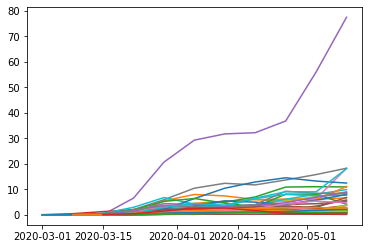

In [76]:
# show changes in test availability over time (increasing mostly)
full_data = full_data.sort_values('Sunday')
for st in full_data['State'].unique():
    tmp = full_data[full_data['State'] == st]
    plt.plot(tmp['Sunday'], tmp['availability'])
plt.show()

## COVID-19 case estimation

For each week, compute the posterior of COVID. Upscale predictions from ILI-level to the state's population.

In [77]:
results = []
for week in full_data.Sunday.unique():
    print(week)
    est = compute_prior(full_data, week)
    est = compute_posterior(est, prior_percentile_equiv=5)
    
    n_ili_covid = (est['ILITOTAL'] * est['%pos_adj']).sum() / 100
    n_ili = est['ILITOTAL'].sum()
    
    print(f'{n_ili_covid} out of {n_ili} ILI\n')
    
    results.append(est)
results = pd.concat(results, axis=0)
results = results[['Sunday', '%pos_adj', '%UNWEIGHTED ILI', 'ILITOTAL', 'NUM. OF PROVIDERS', 'TOTAL PATIENTS', '%ili_smooth', 'availability']]
results = results.reset_index()

2020-03-01T00:00:00.000000000
30190.06745052407 out of 75896.0 ILI

2020-03-08T00:00:00.000000000
24501.273853014056 out of 88912.0 ILI

2020-03-15T00:00:00.000000000
14301.994051196903 out of 78289.0 ILI

2020-03-22T00:00:00.000000000
10262.201557603577 out of 52888.0 ILI

2020-03-29T00:00:00.000000000
9199.11639511763 out of 36066.0 ILI

2020-04-05T00:00:00.000000000
6532.238263002763 out of 24732.0 ILI

2020-04-12T00:00:00.000000000
4356.4506375685205 out of 17984.0 ILI

2020-04-19T00:00:00.000000000
2918.384837703039 out of 14926.0 ILI

2020-04-26T00:00:00.000000000
1987.8596558439829 out of 12644.0 ILI

2020-05-03T00:00:00.000000000
1361.3635481352208 out of 10789.0 ILI

2020-05-10T00:00:00.000000000
929.0505359915255 out of 9928.0 ILI



In [124]:
def true_p_under_bias(p_obs, propensity_scale):
    return p_obs / (propensity_scale - propensity_scale * p_obs + p_obs)

adj_df = []
for st in results['State'].unique():
    tmp = results[results['State'] == st].copy()
    tmp = tmp[tmp['Sunday'] < '2020-04-05']
    max_avail = max(tmp.availability)
    min_avail = min(tmp.availability)
    
    # alpha is the increased probability factor
    alpha = 1.1
    a = (alpha - 1) / (min_avail - max_avail)
    b = 1 - a * max_avail
    
    tmp['propensity'] = a * tmp.availability + b
    tmp['p_final'] = tmp.apply(lambda x: true_p_under_bias(x['%pos_adj'] / 100, x['propensity']), axis=1) * 100
    adj_df.append(tmp)
adj_df = pd.concat(adj_df, axis=0)

In [125]:
adj_df

,State,Sunday,%pos_adj,%UNWEIGHTED ILI,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS,%ili_smooth,availability,%ILI_adj,Case Count,propensity,p_final
0,Alabama,2020-03-01,0.000000,6.325490,3090.0,97.0,48850.0,6.325486,0.000000,6.325486,0.000000,1.100000,0.000000
72,Alabama,2020-03-08,28.520084,6.105610,2968.0,97.0,48611.0,6.215820,0.000410,6.215820,19371.089065,1.099813,26.620786
142,Alabama,2020-03-15,9.367377,6.645860,2427.0,94.0,36519.0,6.337366,0.018818,6.337366,6486.816806,1.091437,8.650493
172,Alabama,2020-03-22,15.526946,4.647150,1319.0,93.0,28383.0,5.771779,0.076269,5.771779,9792.657560,1.065296,14.715284
232,Alabama,2020-03-29,14.495898,3.238930,772.0,93.0,23835.0,4.004366,0.219771,4.004366,6342.839947,1.000000,14.495898
...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,Virgin Islands,2020-03-22,28.758170,0.000000,0.0,1.0,223.0,1.113173,0.166976,0.834879,57.252615,1.058064,27.615824
258,Virgin Islands,2020-03-29,22.648632,0.729927,2.0,2.0,274.0,0.402414,0.376258,0.301811,16.299984,1.000000,22.648632
134,Puerto Rico,2020-03-15,4.497189,15.462800,137.0,6.0,886.0,15.462754,0.216704,11.597065,3712.009969,1.100000,4.105137
200,Puerto Rico,2020-03-22,5.380494,8.551480,98.0,7.0,1146.0,11.564961,0.469488,8.673720,3321.600478,1.080467,4.999819


In [126]:
results = results[results.Sunday < '2020-04-05']
results

,State,Sunday,%pos_adj,%UNWEIGHTED ILI,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS,%ili_smooth,availability,%ILI_adj,Case Count
0,Alabama,2020-03-01,0.000000,6.32549,3090.0,97.0,48850.0,6.325486,0.000000,6.325486,0.000000
1,Delaware,2020-03-01,26.658323,2.46723,32.0,7.0,1297.0,2.467232,0.000000,3.116504,1802.937783
2,Georgia,2020-03-01,100.000000,5.44455,4398.0,99.0,80778.0,5.444552,0.000062,5.444552,128827.271061
3,Illinois,2020-03-01,3.410060,5.52669,4968.0,190.0,89891.0,5.526693,0.000768,6.981086,6722.806065
4,Missouri,2020-03-01,100.000000,9.83182,228.0,12.0,2319.0,9.831824,0.000431,13.880222,189849.469255
...,...,...,...,...,...,...,...,...,...,...,...
260,Missouri,2020-03-29,9.149881,1.17302,8.0,12.0,682.0,2.391975,20.671296,3.376906,4226.174338
261,Wyoming,2020-03-29,9.347463,2.82282,47.0,13.0,1665.0,3.141361,0.807155,2.792321,336.653746
262,Pennsylvania,2020-03-29,16.425563,3.67279,1307.0,121.0,35586.0,4.325835,0.957695,5.464212,25606.593465
263,Nebraska,2020-03-29,8.579340,2.49452,182.0,64.0,7296.0,2.934930,0.355088,4.143430,1532.457681


In [127]:
# Same values from divergence-analysis.ipynb for regional ILI scaling

# Load state populations.
pop_map = pd.read_csv('../COVID-hospitalization-US/data/demographic_data/census-state-population.csv')
pop_map = pop_map.append({'State' : 'New York City' , 'N' : 8623000} , ignore_index=True)  # Add NYC.
pop_map = pop_map.append({'State' : 'Virgin Islands' , 'N' : 107000} , ignore_index=True)  # Add NYC.

pop_map = pop_map.set_index('State').to_dict()['N']
pop_map['New York'] = pop_map['New York'] - pop_map['New York City']

# ILI baselines by region.
ili_baselines = {
    1: 1.9,
    2: 3.2,
    3: 1.9,
    4: 2.4,
    5: 1.9,
    6: 3.8, 
    7: 1.7,
    8: 2.7,
    9: 2.4,
    10: 1.5
}

# States by region.
states_regions = {
    1: ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont'],
    2: ['New Jersey', 'New York', 'Puerto Rico', 'Virgin Islands', 'New York City'],
    3: ['Delaware', 'District of Columbia','Maryland', 'Pennsylvania', 'Virginia', 'West Virginia'],
    4: ['Alabama', 'Florida', 'Georgia', 'Kentucky', 'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee'],
    5: ['Illinois', 'Indiana', 'Michigan', 'Minnesota', 'Ohio', 'Wisconsin'],
    6: ['Arkansas', 'Louisiana', 'New Mexico', 'Oklahoma', 'Texas'], 
    7: ['Iowa', 'Kansas', 'Missouri', 'Nebraska'],
    8: ['Colorado', 'Montana', 'North Dakota', 'South Dakota', 'Utah', 'Wyoming'],
    9: ['Arizona', 'California', 'Hawaii', 'Nevada'],
    10: ['Alaska', 'Idaho', 'Oregon', 'Washington']
}

# Baseline by state.
baseline_state = {}
for region in states_regions.keys():
    for state in states_regions[region]:
        baseline_state[state] = ili_baselines[region]
baseline_state['United States'] = 2.4


# set values to match divergence analysis
p_visit = 0.078
p_visit_given_ili_postcovid = 0.35

In [128]:
results['%ILI_adj'] = results.apply(
    lambda x: x['%ili_smooth'] / baseline_state[x.State] * baseline_state['United States'],
    axis=1)

results['Case Count'] = results.apply(
    lambda x: 1e-4 * x['%ILI_adj'] * x['%pos_adj'] * p_visit / p_visit_given_ili_postcovid * pop_map[x.State],
    axis=1)

In [129]:
adj_df['%ILI_adj'] = adj_df.apply(
    lambda x: x['%ili_smooth'] / baseline_state[x.State] * baseline_state['United States'],
    axis=1)

adj_df['Case Count'] = adj_df.apply(
    lambda x: 1e-4 * x['%ILI_adj'] * x['p_final'] * p_visit / p_visit_given_ili_postcovid * pop_map[x.State],
    axis=1)

In [130]:
results['Case Count'].sum()

5058191.41253216

In [131]:
adj_df['Case Count'].sum()

4911192.159509299

In [132]:
res1 = results.groupby('State').sum()['Case Count']
res2 = adj_df.groupby('State').sum()['Case Count']

In [133]:
comb = pd.concat([res1, res2], axis=1)
comb.columns = ['orig', 'sens']
comb

,orig,sens
State,,
Alabama,41993.403378,39695.043441
Alaska,799.389086,757.686547
Arizona,35617.982351,33458.879012
Arkansas,8177.055960,7645.873643
California,642287.737712,626447.304460
Colorado,47523.312186,44911.444688
Connecticut,82576.535046,79213.106584
Delaware,9949.533172,9382.458748
District of Columbia,5671.622296,5390.070952


In [134]:
tmp = (comb['sens'] / comb['orig']).dropna()
np.quantile(tmp, q=[0.25, 0.5, 0.75])

array([0.94466255, 0.95134319, 0.97033165])